# UFC Fight Analysis


## Todo


1. Change landed and attempted data into percentages.
2. Rewrite models to account for the unbalanced data.
  1. Most fights are won by decision, so that should be accounted for


## Introduction

## Background

## Data

This data was forked from the [UFC Predictor and Notes](https://www.kaggle.com/calmdownkarm/ufc-predictor-and-notes) kaggle kernel. They scraped the data using Beautiful Soup and a Javascript API that pulled fighter data from ufc.com. The scripts pulled data from JSON objects and wrote them to a CSV. All data is from 2014 onwards and consists of fighter statistics merged with fight outcomes. They were unable to get data with the same level of detail in prior years, so all fighter records were reset to zero at the beginning of 2014 and built from there. It was an interesting project and I wanted to see if I could push it further.

In [1]:
# Imports and Helper Functions
# data Analysis
import pandas as pd
import numpy as np
import random as rng
from pprint import pprint
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#SciKit Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from subprocess import check_output
print check_output(["ls", "data"]).decode("utf8")
data = pd.read_csv("data/data.csv")
# Any results you write to the current directory are saved as output.

# Noteboook Functionality
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

data.csv
data.csv.zip



In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Columns: 895 entries, BPrev to winner
dtypes: float64(873), int64(13), object(9)
memory usage: 10.1+ MB


## Variables

There are 895 variables, so it might be worth looking through them to get a better sense of the data. Right now, I'm only aware of a handful of variables and have no idea how many missing values are in the dataset. At least listing the variable names will allow me to categorize them and possibly engineer new features.

In [3]:
var_list = data.columns.values.tolist()
pprint(var_list[:100])
pprint(var_list[100:200])
pprint(var_list[200:300])
pprint(var_list[300:400])
pprint(var_list[400:500])
pprint(var_list[500:600])
pprint(var_list[600:700])
pprint(var_list[700:800])
pprint(var_list[800:895])

['BPrev',
 'BStreak',
 'B_Age',
 'B_Height',
 'B_HomeTown',
 'B_ID',
 'B_Location',
 'B_Name',
 'B_Weight',
 'B__Round1_Grappling_Reversals_Landed',
 'B__Round1_Grappling_Standups_Landed',
 'B__Round1_Grappling_Submissions_Attempts',
 'B__Round1_Grappling_Takedowns_Attempts',
 'B__Round1_Grappling_Takedowns_Landed',
 'B__Round1_Strikes_Body Significant Strikes_Attempts',
 'B__Round1_Strikes_Body Significant Strikes_Landed',
 'B__Round1_Strikes_Body Total Strikes_Attempts',
 'B__Round1_Strikes_Body Total Strikes_Landed',
 'B__Round1_Strikes_Clinch Body Strikes_Attempts',
 'B__Round1_Strikes_Clinch Body Strikes_Landed',
 'B__Round1_Strikes_Clinch Head Strikes_Attempts',
 'B__Round1_Strikes_Clinch Head Strikes_Landed',
 'B__Round1_Strikes_Clinch Leg Strikes_Attempts',
 'B__Round1_Strikes_Clinch Leg Strikes_Landed',
 'B__Round1_Strikes_Clinch Significant Kicks_Attempts',
 'B__Round1_Strikes_Clinch Significant Kicks_Landed',
 'B__Round1_Strikes_Clinch Significant Punches_Attempts',
 'B__Rou

## Description
From this, we can see that we have a total of 879 Columns and one dependent variable. 
The columns themselves have 4 integer types (Streaks, Previous Wins etc), 5 object types (Names, Winner - basically strings and arrays) and 870 Float types. 
This however does not give us a complete picture of our data, so we're using a few other pandas functions to get a better glimpse. 
We also had to engineer a few features that weren't available in the JSONs as explained in the data explanation in the introduction of the project. 

In [4]:
data.describe()

,BPrev,BStreak,B_Age,B_Height,B_ID,B_Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,B__Round1_Grappling_Takedowns_Attempts,...,R__Round5_TIP_Distance Time,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time
count,1477.000000,1477.000000,1474.000000,1476.000000,1477.000000,1477.000000,978.000000,978.000000,978.000000,978.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.735274,0.654705,30.954545,177.451220,1964.633040,73.804333,0.036810,0.896728,0.431493,2.986708,...,211.965278,34.062500,66.604167,5.527778,4.319444,5.138889,12.097222,224.965278,4.562500,263.069444
std,1.895561,1.057269,4.020311,8.561541,666.949141,14.980531,0.193748,1.255722,0.830527,3.987291,...,139.412374,68.819742,94.574736,22.374419,12.854023,14.312013,36.429320,142.328509,19.698681,162.386212
min,0.000000,0.000000,20.000000,152.000000,129.000000,52.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,28.000000,172.000000,1755.000000,65.000000,0.000000,0.000000,0.000000,0.000000,...,110.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.750000,0.000000,139.000000
50%,1.000000,0.000000,31.000000,177.000000,2156.000000,70.000000,0.000000,0.000000,0.000000,2.000000,...,214.000000,0.000000,9.500000,0.000000,0.000000,0.000000,0.000000,232.000000,0.000000,291.000000
75%,3.000000,1.000000,34.000000,182.000000,2337.000000,84.000000,0.000000,1.000000,1.000000,4.000000,...,294.500000,47.500000,109.000000,0.000000,0.000000,0.000000,2.000000,299.000000,0.000000,300.000000
max,11.000000,7.000000,46.000000,213.000000,2882.000000,120.000000,2.000000,9.000000,6.000000,33.000000,...,647.000000,496.000000,529.000000,144.000000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [5]:
data.describe(include=['O'])

,B_HomeTown,B_Location,B_Name,Date,R_HomeTown,R_Location,R_Name,winby,winner
count,1471,1470,1477,1477,1477,1476,1477,1461,1477
unique,568,431,719,224,495,390,633,3,4
top,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Tim Means,07/11/2016,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Donald Cerrone,DEC,red
freq,32,38,8,32,44,67,11,720,867


In [6]:
data.describe(include=[np.int])

,BPrev,BStreak,B_ID,B_Weight,Event_ID,Fight_ID,Last_round,Max_round,RPrev,RStreak,R_Height,R_ID,R_Weight
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,1.735274,0.654705,1964.633040,73.804333,733.943805,5583.656060,2.417062,3.208531,2.125254,0.721733,177.436696,1766.935003,73.935003
std,1.895561,1.057269,666.949141,14.980531,50.851452,611.609705,0.990158,0.605850,1.979199,1.136555,8.667657,697.191563,15.069751
min,0.000000,0.000000,129.000000,52.000000,646.000000,4521.000000,1.000000,3.000000,0.000000,0.000000,154.000000,129.000000,52.000000
25%,0.000000,0.000000,1755.000000,65.000000,687.000000,5016.000000,1.000000,3.000000,1.000000,0.000000,172.000000,1253.000000,65.000000
50%,1.000000,0.000000,2156.000000,70.000000,738.000000,5580.000000,3.000000,3.000000,2.000000,0.000000,177.000000,2015.000000,70.000000
75%,3.000000,1.000000,2337.000000,84.000000,780.000000,6142.000000,3.000000,3.000000,3.000000,1.000000,185.000000,2255.000000,84.000000
max,11.000000,7.000000,2882.000000,120.000000,816.000000,6627.000000,5.000000,5.000000,12.000000,9.000000,213.000000,2870.000000,120.000000


In [59]:
count = loc_data['B_Location'].str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

2 words:    270
3 words:    523
4 words:    457
5 words:    171
6 words:     16
7 words:      4
Name: B_Location, dtype: int64

In [222]:
data['winby'].value_counts()

DEC       717
KO/TKO    454
SUB       278
Name: winby, dtype: int64

In [223]:
data['winner'].value_counts()

red     865
blue    584
Name: winner, dtype: int64

### Some Notes to observe
1. Red Side seems to win slightly more than blue (867/1477 = 58.7%)
2. Donald Cerrone fights on Red side more than any other fighter, with 11 fights
3. Tim Means fights on Blue side more than any other fighter with 8
4. There are more fighters fighting debut fights. This statistic however could be skewed by the fact that our data set assumes debuts of every fighter in 2013
5. Most Fights are won by decision, and 2015 had the most fights. 
6. The Most common hometown and training location for fighters is Rei De Janeiro in Brazil
We also notice that 3 fighters don't have an age and 1 doesn't have a height. 

In [108]:
data.head()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
0,1,1,23.0,182.0,Trento Italy,2783,Mezzocorona Italy,Marvin Vettori,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
2,2,0,38.0,172.0,Kanagawa Japan,721,Tokyo Japan,Takanori Gomi,70,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KO/TKO,red
3,0,0,23.0,170.0,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
4,3,1,30.0,167.0,"Spokane, WA USA",2260,"Spokane, WA USA",Elizabeth Phillips,61,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red


In [109]:
data.tail()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1472,0,0,26.0,172.0,"Tlaltenango, Zacatecas Mexico",2355,"San Diego, California USA",Jose Quinonez,61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1473,2,1,26.0,165.0,"Tampa, Florida USA",2610,"Tampa, Florida USA",Geane Herrera,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1474,3,2,36.0,187.0,"Doylestown, Pennsylvania USA",1694,"Dana Point, California USA",Patrick Cummins,93,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,blue
1475,3,1,31.0,167.0,Irvine Scotland,2339,Glasgow Scotland,Joanne Calderwood,52,0.0,...,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,KO/TKO,blue
1476,2,1,31.0,187.0,The Netherlands,786,"Leiden, Holland The Netherlands",Gegard Mousasi,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,red


## Data Cleaning

The first step in data cleaning is to remove obvious outliers and columns that will not contribute to the model. One starting point is narrowing down the fights to just wins and losses, excluding no contests and draws. No contests are nearly impossible to predict as are draws, so it doesn't make sense to account for them. Here's a list of ideas so far:

1. Draws or no contest ['winner']
2. Blue and red ID
3. Blue and red Name
4. Blue and red Name
5. Date

The data is currently not in "tidy" format, so I may consider reshaping it. One obvious hint that this is the case is that every row has a round_4 and round_5 column, even though not all fights go to the last round. I'll see what I can do in terms of reshaping the data and look into whether it makes sense to do so. I wonder if there's a dplyr and tidyr package for Python? The R equivalents are pretty robust, so I'll probably start there. Here's an ongoing list of ideas that may be worth pursuing:

1. Rearrange data to get rid of empty Round4 and Round5 data
2. Separate city and country (Brazil vs RioDijanero Brazil and USA vs Stockton, California USA may add more predictive power)
3. Change landed and attempted data into percentages. This may help make better comparisons across fighters making debuts vs fighters with established records.
4. Add a column for submission wins, KO wins, etc

I'm debating whether to turn the database into a database of fighters instead of a database of fights. One reason is that you have the accumulated statistics on each fighter's history going into each event. If you have Jon Jones matching up against DC, it may be useful to ask, "What is it about Jon Jones' record that makes him a favorite? This may require a lot or rearranging, so it may be worth it to think this through a bit first.

If I were to go this route, I would reset each fighter's stats and only add stats that came prior to each fight. For example, if Frankie Edgar fought in 2013 against Anderson Silva and then fought again against Matt Hughes in 2014, I'd want their fighter record inputs to be different. I think this may be a more comprehensive way of looking at the data and would align more closely to real-world applications. Here's a rough sketch of what the process might look like:

1. Sort the dataframe by date
2. Add each fighter's stats cumulatively based on prior fights
  1. Figure out a way to accomplish this even though red is on one side and blue is on the other
  2. Maybe put fighters on just red or blue? Might be impossible..
  3. Maybe just account for this in the code? If B_Name == 'X' do this or if R_Name == 'X' do that
3. Add columns for kicks taken, punches taken, etc?
  1. One disadvantage is that this would mean nearly doubling the number of variables in a dataset that is already massive. This will hurt some machine learning models. Actually, this could lead to more variables than observations which would be no bueno, although it would still be possible to pare it down afterwards. Let's omit this for now and come back to it later if necessary.
4. Consider consolidating round data. Why do you need 5 rounds of data for each fighter? Consider building a granular model and an aggragated model.

The head() and tail() functions give us a snapshot of the dataset's values. Not all rows and columns are represented, but it gives just enough to get a sense of how the data is organized. There are many NaN values and they need to be changed before passing the data onto the classifiers, but I want to be careful before making any changes. For instance, the winby column is extremely unbalanced and it may make sense to get rid of some of the outliers. For instance, there are a total of 16 draws and no-contests out of 1477. It makes no sense to include these since they are anomolies, so I will drop them.

### Extracting Country from B_Location and R_Location

I want to extract each figher's country location. Currently there are 438 unique locations in the dataset. This is too many categories to get a sense of where fighters are training. There may also be some correlation between a fighter's location and his or her record. The first thing I did was exclude any fighters with null values for their current location. Thankfully, there were only 8 such cases. Then I cleaned up some of the mispellings / duplicate entries (USA and United States were consolidated into just USA). Finally, I replaced all [City Country] values to [Country] values.

In [89]:
data['B_Location'].value_counts()[:10]

Rio de Janeiro Brazil                  38
Denver, Colorado USA                   25
Albuquerque, New Mexico USA            24
Coconut Creek, Florida USA             21
Sacramento, California USA             20
San Diego, California United States    19
Glendale, Arizona USA                  16
Montreal, Quebec Canada                16
Las Vegas, Nevada USA                  16
Coconut Creek, FL USA                  15
Name: B_Location, dtype: int64

In [37]:
data = data[data['winby'].notnull()]
loc_data = data[(data['B_Location'].notnull()) & data['R_Location'].notnull()]
data = data[data['winner'] != 'no contest']
#data = data.reset_index()

In [86]:
len(loc_data)
len(data)

1441

1449

In [54]:
locations = ['B_Location', 'R_Location']
countries = ['Japan','Singapore']
for location in locations:
    for country in countries:
        loc_data.loc[(loc_data[location] == country), location] = 'Unknown '+country

In [90]:
locations = ['B_Location', 'R_Location']
c_dict = {
    'United': 'USA',
    'Brasil': 'Brazil',
    'Englad': 'England',
    'Czech': 'CzechRepublic',
    'Moldova': 'Moldova',
}

post_c_dict = {
    'Africa': 'South Africa',
    'CzechRepublic': 'Czech Republic',
    'PAN': 'Panama',
    'Zealand': 'New Zealand'
}
countries = ['']
for location in locations:
    for k,v in c_dict.items():
        loc_data.loc[loc_data[location].str.contains(k), location] = v
new_cols = ['R_Country_Location', 'B_Country_Location']
for new_col, location in zip(new_cols, locations):
    loc_data[new_col] = loc_data[location].str.split().str[-1]
for col in new_cols:
    for k,v in post_c_dict.items():
        loc_data.loc[loc_data[col].str.contains(k), col] = v

for location, col in zip(locations, new_cols):
    loc_data[location] = loc_data[col]
    del loc_data[col]
sorted(set(loc_data['B_Location'].values.tolist()))

['Argentina',
 'Australia',
 'Brazil',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Ecuador',
 'England',
 'Finland',
 'France',
 'Germany',
 'Guam',
 'Iceland',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Moldova',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Romania',
 'Russia',
 'Scotland',
 'Serbia',
 'Singapore',
 'South Africa',
 'Spain',
 'Sweden',
 'Taiwan',
 'Thailand',
 'USA',
 'Ukraine',
 'Wales']

In [85]:
loc_data['B_Country_Location'].value_counts()

USA               797
Brazil            222
Canada             76
England            49
Australia          46
Ireland            30
Japan              24
Mexico             24
Sweden             21
Russia             17
Poland             17
Korea              14
China              13
Netherlands        13
Germany            11
France              8
Scotland            7
Ukraine             6
Spain               4
Peru                3
Singapore           3
Iceland             3
Finland             3
South Africa        3
Czech Republic      3
Wales               2
Ecuador             2
Thailand            2
Croatia             2
Denmark             2
New Zealand         2
Guam                2
Philippines         2
Moldova             1
Chile               1
Serbia              1
Paraguay            1
Austria             1
Panama              1
Greece              1
Italy               1
Name: B_Country_Location, dtype: int64

In [213]:
data.fillna(value=0,inplace=True)

In [214]:
data.tail()

,index,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1444,1472,0,0,26.0,172.0,"Tlaltenango, Zacatecas Mexico",2355,"San Diego, California USA",Jose Quinonez,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1445,1473,2,1,26.0,165.0,"Tampa, Florida USA",2610,"Tampa, Florida USA",Geane Herrera,56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
1446,1474,3,2,36.0,187.0,"Doylestown, Pennsylvania USA",1694,"Dana Point, California USA",Patrick Cummins,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,blue
1447,1475,3,1,31.0,167.0,Irvine Scotland,2339,Glasgow Scotland,Joanne Calderwood,52,...,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,KO/TKO,blue
1448,1476,2,1,31.0,187.0,The Netherlands,786,"Leiden, Holland The Netherlands",Gegard Mousasi,84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,red


In [215]:
dropdata = data.drop(['B_ID','B_Name','R_ID','R_Name','Date'],axis=1)
dropdata.rename(columns={'BPrev':'B__Prev',
                         'RPrev':'R__Prev',
                         'B_Age':'B__Age',
                         'B_Height':'B__Height',
                         'B_Weight':'B__Weight',
                         'R_Age':'R__Age',
                         'R_Height':'R__Height',
                         'R_Weight':'R__Weight',
                         'BStreak':'B__Streak',
                         'RStreak': 'R__Streak'},inplace=True)
dropdata.describe()

,index,B__Prev,B__Streak,B__Age,B__Height,B__Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,B__Round1_Grappling_Submissions_Attempts,B__Round1_Grappling_Takedowns_Attempts,...,R__Round5_TIP_Distance Time,R__Round5_TIP_Ground Control Time,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,...,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,737.886818,1.743271,0.656315,30.882678,177.328502,73.753623,0.024155,0.596273,0.287095,1.990338,...,21.064872,3.385093,6.619048,0.549344,0.429262,0.510697,1.202208,22.356798,0.453416,26.143547
std,427.568003,1.894033,1.057349,4.239225,9.760730,14.921874,0.158015,1.101487,0.709334,3.558690,...,77.094035,23.909115,35.786002,7.223290,4.241257,4.753313,12.006955,80.829225,6.339231,93.821691
min,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.000000,0.000000,0.000000,28.000000,172.000000,65.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,739.000000,1.000000,0.000000,31.000000,177.000000,70.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1109.000000,3.000000,1.000000,34.000000,182.000000,84.000000,0.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1476.000000,11.000000,7.000000,46.000000,213.000000,120.000000,2.000000,9.000000,6.000000,33.000000,...,647.000000,496.000000,529.000000,144.000000,91.000000,62.000000,264.000000,659.000000,128.000000,841.000000


In [216]:
dropdata.describe(include=['O'])

,B_HomeTown,B_Location,R_HomeTown,R_Location,winby,winner
count,1449,1449,1449,1449,1449,1449
unique,568,431,489,388,3,2
top,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Rio de Janeiro Brazil,Rio de Janeiro Brazil,DEC,red
freq,32,38,42,66,717,865


In [217]:
dropdata.describe(include=[np.int])

,index,B__Prev,B__Streak,B__Weight,Event_ID,Fight_ID,Last_round,Max_round,R__Prev,R__Streak,R__Height,R__Weight
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.0000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,737.886818,1.743271,0.656315,73.753623,733.897861,5583.006211,2.4196,3.209800,2.131125,0.722567,177.431332,73.908903
std,427.568003,1.894033,1.057349,14.921874,50.767064,610.506493,0.9871,0.607402,1.982152,1.140803,8.681417,15.038210
min,0.000000,0.000000,0.000000,52.000000,646.000000,4521.000000,1.0000,3.000000,0.000000,0.000000,154.000000,52.000000
25%,365.000000,0.000000,0.000000,65.000000,687.000000,5016.000000,1.0000,3.000000,1.000000,0.000000,172.000000,65.000000
50%,739.000000,1.000000,0.000000,70.000000,738.000000,5579.000000,3.0000,3.000000,2.000000,0.000000,177.000000,70.000000
75%,1109.000000,3.000000,1.000000,84.000000,780.000000,6139.000000,3.0000,3.000000,3.000000,1.000000,185.000000,84.000000
max,1476.000000,11.000000,7.000000,120.000000,816.000000,6627.000000,5.0000,5.000000,12.000000,9.000000,213.000000,120.000000


Next we need to convert our object types of columns into categorical columns. This is done to sort by logical order

In [218]:
objecttypes = list(dropdata.select_dtypes(include=['O']).columns)
for col in objecttypes:
    dropdata[col] = dropdata[col].astype('category')

In [219]:
cat_columns = dropdata.select_dtypes(['category']).columns
dropdata[cat_columns] = dropdata[cat_columns].apply(lambda x: x.cat.codes)
dropdata.info()
dropdata.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Columns: 891 entries, index to winner
dtypes: float64(873), int16(4), int64(12), int8(2)
memory usage: 9.8 MB


,index,B__Prev,B__Streak,B__Age,B__Height,B_HomeTown,B_Location,B__Weight,B__Round1_Grappling_Reversals_Landed,B__Round1_Grappling_Standups_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1444,1472,0,0,26.0,172.0,505,331,61,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1445,1473,2,1,26.0,165.0,491,378,56,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1446,1474,3,2,36.0,187.0,125,110,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1447,1475,3,1,31.0,167.0,210,154,52,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,301.0,0.0,301.0,1,0
1448,1476,2,1,31.0,187.0,501,209,84,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1


## Data Correlation
While it would otherwise be normal practise to draw a heatmap or correlation matrix of our data to look for linear relationships, this is highly illogical due to the sheer number of features we're currently looking at.  Instead we examine the n largest correlations with our dependent variable (winner) to look for linear relationships - as you can see from the plot below, the relationships (if they exist) are highly non-linear. This suggests that alterations to our Data Set are required. 

Further, it seems that Round 4 statistics for the Red Fighter are the more correlating, this suggests that a split or delta sort of data set should produce better results. 

In [220]:
# Basic Correlation Matrix
# corrmat = data.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

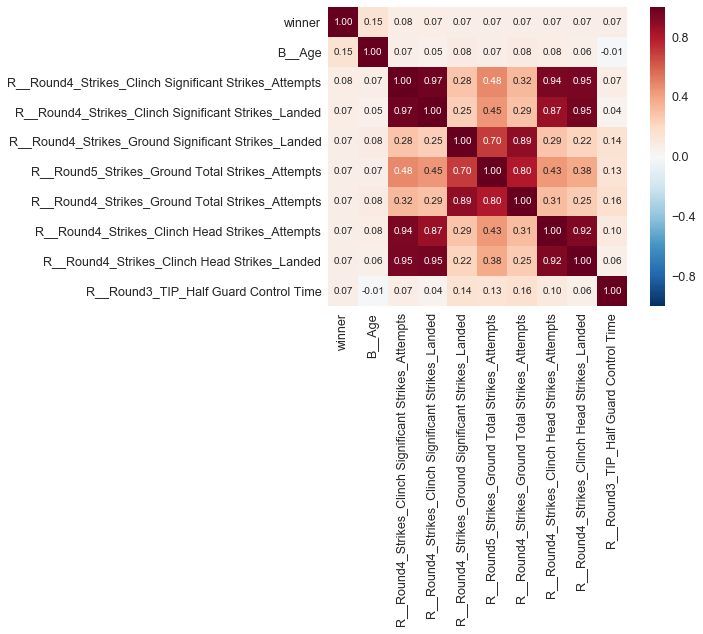

In [224]:
# Subset Correlation Matrix
k = 10 #number of variables for heatmap
corrmat = dropdata.corr()
cols = corrmat.nlargest(k, 'winner')['winner'].index
cm = np.corrcoef(dropdata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Modeling
We're evaluating the following models

1. Perceptron
2. Random Forests
3. Decision Trees Classifier
4. SGD Classifier
5. Linear SVC
6. Gaussian NB
7. KNN

I each model's random_state when appropriate and set the SVM's class_weight to balanced to account for the unbalanced data. There's a lot that can be done in terms of tuning the hyperparameters. I may have to come back to this later to further test different configurations.

In [232]:
# help(sklearn.ensemble.RandomForestClassifier())
# help(sklearn.naive_bayes.GaussianNB)
help(sklearn.svm.LinearSVC)
# import sklearn
# help(sklearn)

Help on class LinearSVC in module sklearn.svm.classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : string, 'l1' or 'l2' (default='l2')
 |      Specifies the norm used in the penalization. The 'l2'
 |      penalty is the standard used in SVC. The 'l1' leads to ``coef_``
 |      vectors that are sparse.
 |  
 |  loss : string, 'hinge' or 'squared_hinge' (defau

In [239]:
# We Store prediction of each model in our dict
# Helper Functions for our models. 

def percep(X_train,Y_train,X_test,Y_test,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001, random_state=42)
    perceptron.fit(X_train, Y_train)
    Y_pred = perceptron.predict(X_test)
    Models['Perceptron'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1,
                                       random_state=42
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier(class_weight="balanced",random_state=42)
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def SGDClass(X_train,Y_train,X_test,Y_test,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001, class_weight = "balanced", random_state=42)
    sgd.fit(X_train, Y_train)
    Y_pred = sgd.predict(X_test)
    Models['SGD Classifier'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def linSVC(X_train,Y_train,X_test,Y_test,Models):
    linear_svc = LinearSVC(class_weight="balanced", random_state=42)
    linear_svc.fit(X_train, Y_train)
    Y_pred = linear_svc.predict(X_test)
    Models['SVM'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

def Nearest(X_train,Y_train,X_test,Y_test,Models):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    Models['KNN'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]

def run_all_and_Plot(df):
    Models = dict()
    from sklearn.model_selection import train_test_split
    X_all = df.drop(['winner'], axis=1)
    y_all = df['winner']
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
    percep(X_train,Y_train,X_test,Y_test,Models)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    SGDClass(X_train,Y_train,X_test,Y_test,Models)
    linSVC(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    Nearest(X_train,Y_train,X_test,Y_test,Models)
    return Models


def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    plt.show()


def plot_cm(dict):
    count = 1
    fig = plt.figure(figsize=(10,10))
    for model in dict:
        cm = dict[model][1]
        labels = ['W','L']
        ax = fig.add_subplot(4,4,count)
        cax = ax.matshow(cm)
        plt.title(model,y=-0.8)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.subplot(2,2,count)
        count+=1
    plt.tight_layout()
    plt.show()

KNN 0.472413793103
SVM 0.444827586207
Decision Tree 0.513793103448
Random Forests 0.534482758621
SGD Classifier 0.510344827586
Bayes 0.486206896552
Perceptron 0.548275862069


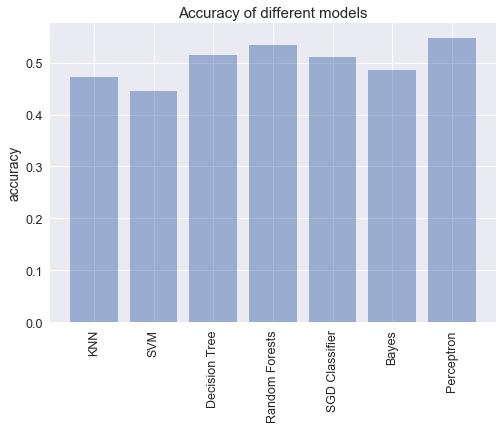

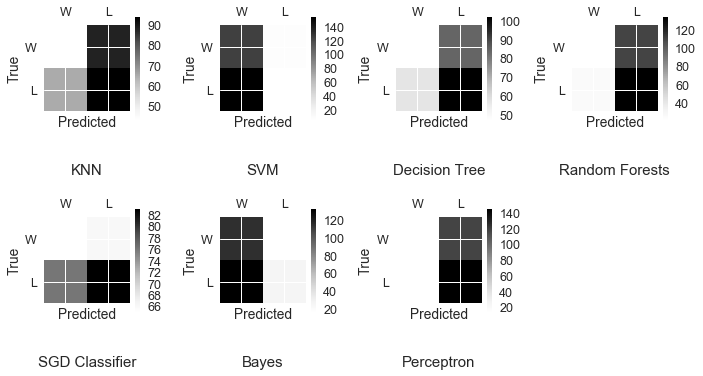

In [238]:
accuracies = run_all_and_Plot(dropdata)
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
plot_bar(accuracies)
plot_cm(accuracies)

Theoretically, we should get best results from our Random Forests Model, thus attempting to tune hyper parameters using GridSearch from Scikit learn

In [145]:
from sklearn.model_selection import train_test_split, GridSearchCV
#X_all = dropdata.drop(['winner'], axis=1)
#y_all = dropdata['winner']
#X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=23)
#rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=None) 
#param_grid = { 
#    'n_estimators': [200,700],
#    'max_features': ['auto', 'sqrt', 'log2']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train, Y_train)
#print(CV_rfc.best_params_)

### Trying to improve results by dividing features

This block turns each individual red and blue round stat into a ratio of red to blue values. It divides the number of features from 895 to 450. For instance, it turns R_Round4_Strikes_Kicks_Landed and B_Round4_Strikes_Kicks_Landed into a single ratio of red to blue strikes kicks landed. Interesting approach, it appears to be part of th iteration process to see what will be most effective in this analysis.

In [179]:
dontchange = ['winner','Event_ID','Fight_ID','Max_round','Last_round','B_Age','R_Age']
numeric_cols = [col for col in dropdata if col not in dontchange]
dropdata[numeric_cols] += 1 

In [180]:
newDF = dropdata.copy()
blue_cols = [col for col in dropdata.columns if 'B__' in col]
red_cols = [col for col in dropdata.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    dropdata[newkey] = dropdata[str(blue)]/dropdata[str(red)]
    del dropdata[str(blue)]
    del dropdata[str(red)]
newDF.head()

,B_HomeTown,B_Location,Event_ID,Fight_ID,Last_round,Max_round,R_HomeTown,R_Location,winby,winner,...,Round5TIPDistance Time,Round5TIPGround Control Time,Round5TIPGround Time,Round5TIPGuard Control Time,Round5TIPHalf Guard Control Time,Round5TIPMisc. Ground Control Time,Round5TIPMount Control Time,Round5TIPNeutral Time,Round5TIPSide Control Time,Round5TIPStanding Time
0,513,245,802,6405,3,3,188,80,2,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,89,294,670,4786,1,3,98,122,4,0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,230,388,729,5523,1,3,55,52,3,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,505,386,790,6240,1,3,163,168,4,0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,466,357,785,6226,3,3,80,84,2,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


KNN 0.472413793103
SVM 0.462068965517
Decision Tree 0.489655172414
Random Forests 0.537931034483
SGD Classifier 0.448275862069
Bayes 0.565517241379
Perceptron 0.548275862069


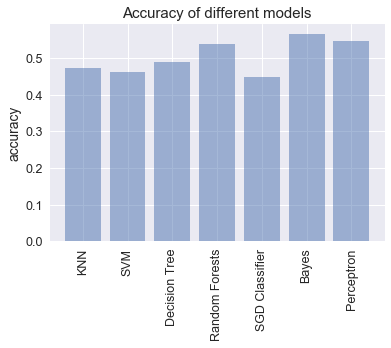

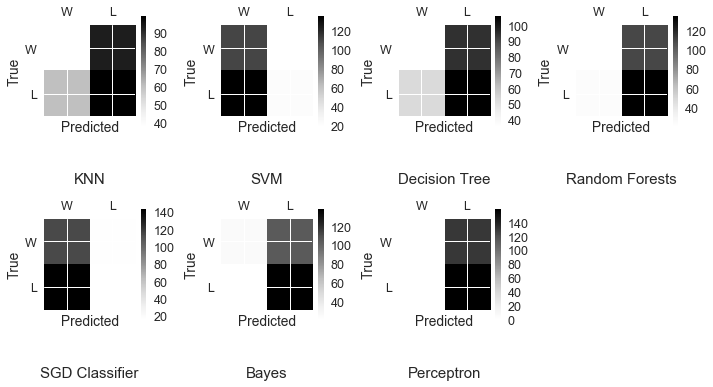

In [181]:
accuracies = run_all_and_Plot(dropdata)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Blue/Red'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


#### Dropping Round 4 and Round 5 since most fights are 3 round Max.

This block drops round 4 and round 5 columns from the dataset but keeps fights that last 5 rounds. It may be an attempt to overcome the amount of null values in the dataset. I'd go a different route since this doesn't seem very precise. I'd tidy and consolidate the data from all rounds into one so there wouldn't be a need to drop round 4 and 5 data. 

KNN 0.472413793103
SVM 0.462068965517
Decision Tree 0.510344827586
Random Forests 0.520689655172
SGD Classifier 0.441379310345
Bayes 0.541379310345
Perceptron 0.548275862069


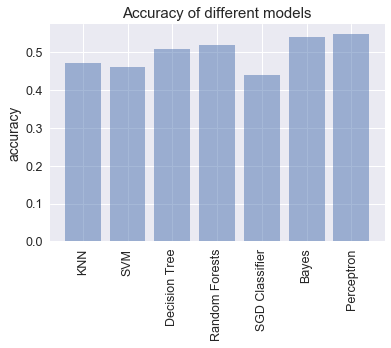

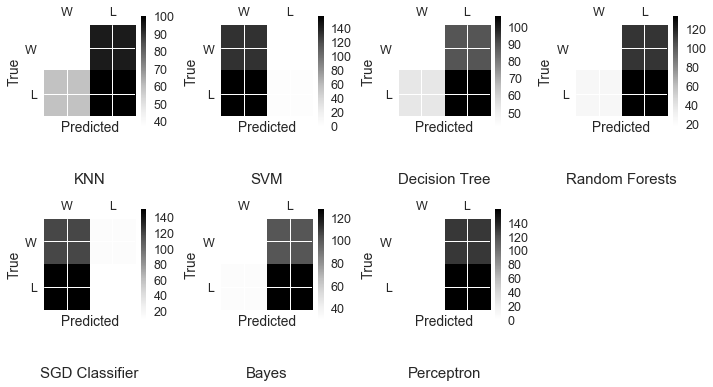

In [182]:
r4 = [col for col in dropdata.columns if "Round4" in col]
r5 = [col for col in dropdata.columns if "Round5" in col]
threerounds = dropdata.drop(r4+r5,axis = 1)
accuracies = run_all_and_Plot(threerounds)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['DropR4&R5'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

#### Dropping 5 round fights entirely

This block drops all title fights. I think this is a mistake for a couple reasons. The dataset is small enough already (only 1477 observations) so dropping any records would probably have a negative impact on the machine learning algorithm. Also, there may be a better way to represent the data that would negate the reasoning behind this step.

KNN 0.472413793103
SVM 0.541379310345
Decision Tree 0.510344827586
Random Forests 0.503448275862
SGD Classifier 0.451724137931
Bayes 0.541379310345
Perceptron 0.548275862069


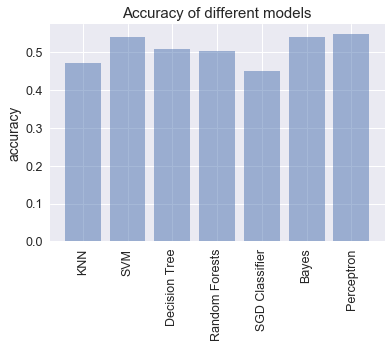

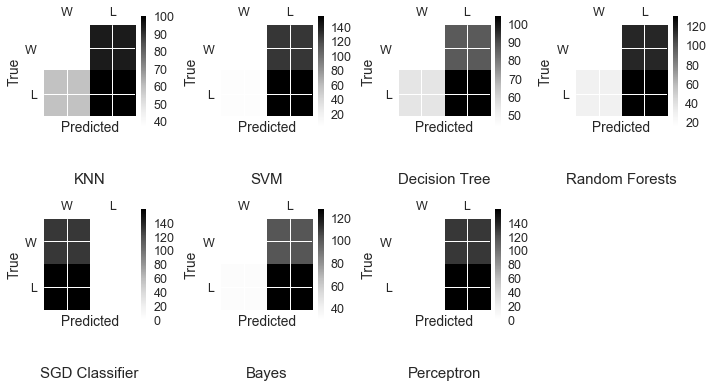

In [183]:
foobar = threerounds.loc[threerounds['Max_round'] == 3]
bewb = threerounds.drop(['Max_round','Last_round'],axis=1)
accuracies = run_all_and_Plot(bewb)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['Drop5RoundFights'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

### Dropping First Fights

This drops any fights in which the fighter has no previous recorded. I may use this in my model but again I'm hesitant to do so because it involves a huge loss of data. Looking at the original CSV, there are 342 records in for Red and 499 records for blue in which they have no previously recorded fight data. I can't afford to lose more than half the data.

This is actually a pretty interesting problem because I'm not sure how to deal with new fighters. By definition, their stats will show up as zeros if they don't have any fight data. It might be worth exploring how to get records prior to 2014 and going from there. Possible sources include:

1. Fightmetrics
2. Fight data from other fight organizations
3. Looking into what the original analyst meant when he said the previous data was not as granular

In [70]:
data[data.RPrev == False]

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,blue
10,4,0,36.0,175.0,"Santa Ana, California USA",2041,"Glendale, Arizona USA",Yaotzin Meza,65,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
11,0,0,27.0,177.0,Fife Scotland,2502,Fife Scotland,Stevie Ray,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,blue
12,0,0,30.0,182.0,"Vicosa, Minas Gerais Brazil",2250,Rio de Janeiro Brazil,Wagner Silva,77,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,red
17,0,0,35.0,172.0,"Miami, Florida USA",2219,"Homestead, Florida USA",Patrick Williams,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
18,0,0,36.0,167.0,"Takoma Park, Maryland United States",2022,"Gaffney, South Carolina United States",Sara McMann,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
19,0,0,33.0,182.0,"Stockton, California USA",506,"Stockton, California USA",Nick Diaz,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,no contest
22,0,0,33.0,177.0,"Linton, North Dakota USA",2273,"Coconut Creek, Florida USA",Leo Kuntz,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,red
24,0,0,37.0,180.0,Limassol Cyprus,1781,"Long Island , New York USA",Costas Philippou,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
26,0,0,37.0,162.0,Dublin Ireland,2196,Dublin Ireland,Neil Seery,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red


In [71]:
data[data.BPrev == False]

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,blue
3,0,0,23.0,170.0,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,blue
5,0,0,38.0,180.0,Tehran Iran,1918,Stockholm Sweden,Reza Madadi,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,red
7,0,0,27.0,177.0,"Jefferson, Iowa USA",2262,"Jefferson, Iowa USA",Johnny Case,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,blue
11,0,0,27.0,177.0,Fife Scotland,2502,Fife Scotland,Stevie Ray,70,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,blue
12,0,0,30.0,182.0,"Vicosa, Minas Gerais Brazil",2250,Rio de Janeiro Brazil,Wagner Silva,77,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUB,red
13,0,0,44.0,177.0,Saigon Vietnam,1001,"San Jose, California USA",Cung Le,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
17,0,0,35.0,172.0,"Miami, Florida USA",2219,"Homestead, Florida USA",Patrick Williams,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
18,0,0,36.0,167.0,"Takoma Park, Maryland United States",2022,"Gaffney, South Carolina United States",Sara McMann,61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KO/TKO,red
19,0,0,33.0,182.0,"Stockton, California USA",506,"Stockton, California USA",Nick Diaz,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,no contest


KNN 0.472413793103
SVM 0.541379310345
Decision Tree 0.510344827586
Random Forests 0.503448275862
SGD Classifier 0.451724137931
Bayes 0.541379310345
Perceptron 0.548275862069


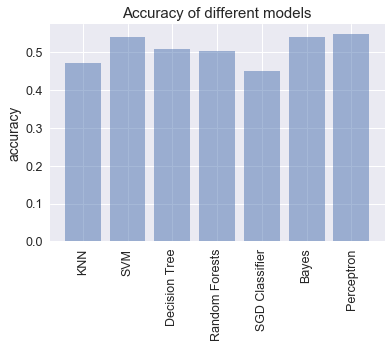

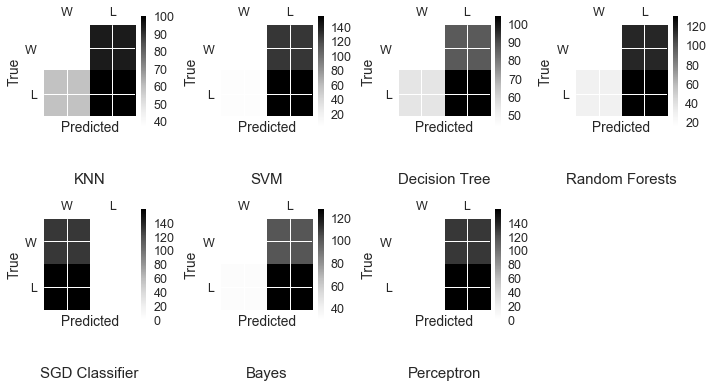

In [184]:
blahblah = bewb[bewb.Prev != 1]
accuracies = run_all_and_Plot(blahblah)
for key,val in accuracies.items():
    print(str(key)+' '+str(val[0]))
CompareAll['DroppingDebut'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

In [73]:
blue_cols

['B__Prev',
 'B__Streak',
 'B__Age',
 'B__Height',
 'B__Weight',
 'B__Round1_Grappling_Reversals_Landed',
 'B__Round1_Grappling_Standups_Landed',
 'B__Round1_Grappling_Submissions_Attempts',
 'B__Round1_Grappling_Takedowns_Attempts',
 'B__Round1_Grappling_Takedowns_Landed',
 'B__Round1_Strikes_Body Significant Strikes_Attempts',
 'B__Round1_Strikes_Body Significant Strikes_Landed',
 'B__Round1_Strikes_Body Total Strikes_Attempts',
 'B__Round1_Strikes_Body Total Strikes_Landed',
 'B__Round1_Strikes_Clinch Body Strikes_Attempts',
 'B__Round1_Strikes_Clinch Body Strikes_Landed',
 'B__Round1_Strikes_Clinch Head Strikes_Attempts',
 'B__Round1_Strikes_Clinch Head Strikes_Landed',
 'B__Round1_Strikes_Clinch Leg Strikes_Attempts',
 'B__Round1_Strikes_Clinch Leg Strikes_Landed',
 'B__Round1_Strikes_Clinch Significant Kicks_Attempts',
 'B__Round1_Strikes_Clinch Significant Kicks_Landed',
 'B__Round1_Strikes_Clinch Significant Punches_Attempts',
 'B__Round1_Strikes_Clinch Significant Punches_Land

### Aggregate Round Stats

This block sums the stats for each round into one value. For example, it combines round 1-5 strikes_landed into a single value. This is what I was thinking of doing. May have to borrow this code in my analysis.

In [185]:
blue_cols
newDF.info()
b_feats = list(set([x[10:] for x in blue_cols if "Round" in x]))
r_feats = list(set([x[10:] for x in red_cols if "Round" in x]))
def sumshit(b_feats,cols):
    for x in b_feats:
        newDF.loc[:,x] = 0
        for y in cols:
            if x in y:
                newDF[x] += newDF[y]
                newDF.drop(y,axis=1,inplace=True)
sumshit(b_feats,blue_cols)
sumshit(r_feats,red_cols)
newDF.info()


[]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1476
Columns: 450 entries, B_HomeTown to Round5TIPStanding Time
dtypes: float64(440), int16(4), int64(4), int8(2)
memory usage: 4.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1476
Columns: 450 entries, B_HomeTown to Round5TIPStanding Time
dtypes: float64(440), int16(4), int64(4), int8(2)
memory usage: 4.9 MB


,B_HomeTown,B_Location,Event_ID,Fight_ID,Last_round,Max_round,R_HomeTown,R_Location,winby,winner,...,Round5TIPDistance Time,Round5TIPGround Control Time,Round5TIPGround Time,Round5TIPGuard Control Time,Round5TIPHalf Guard Control Time,Round5TIPMisc. Ground Control Time,Round5TIPMount Control Time,Round5TIPNeutral Time,Round5TIPSide Control Time,Round5TIPStanding Time
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.0000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,...,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,280.841960,214.585231,733.897861,5583.006211,2.4196,3.209800,250.719807,190.690821,2.697032,0.596963,...,6.048854,2.491198,3.504591,2.359525,2.020944,1.985189,2.222202,6.355715,2.076231,7.468982
std,161.075711,122.971557,50.767064,610.506493,0.9871,0.607402,136.913975,110.810336,0.771558,0.490677,...,31.310684,6.968412,15.289451,6.541775,1.371520,0.164838,4.782710,32.907528,1.636661,38.524417
min,2.000000,2.000000,646.000000,4521.000000,1.0000,3.000000,2.000000,2.000000,2.000000,0.000000,...,1.001543,1.002012,1.001887,1.006897,1.010870,1.015873,1.003774,1.001515,1.007752,1.001188
25%,131.000000,111.000000,687.000000,5016.000000,1.0000,3.000000,132.000000,91.000000,2.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,282.000000,211.000000,738.000000,5579.000000,3.0000,3.000000,253.000000,192.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,423.000000,324.000000,780.000000,6139.000000,3.0000,3.000000,365.000000,282.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,569.000000,432.000000,816.000000,6627.000000,5.0000,5.000000,490.000000,389.000000,4.000000,1.000000,...,585.000000,147.000000,269.000000,146.000000,54.000000,4.000000,167.000000,587.000000,45.000000,598.000000


KNN 0.472413793103
SVM 0.462068965517
Decision Tree 0.489655172414
Random Forests 0.537931034483
SGD Classifier 0.448275862069
Bayes 0.565517241379
Perceptron 0.548275862069


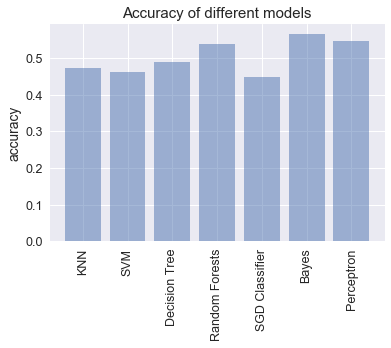

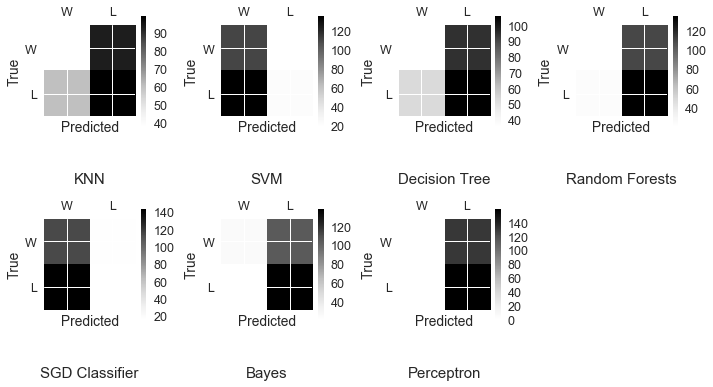

In [186]:
newDF.describe()
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)



### Comparing Red to Blue

This block compares red stats to blue stats. It creates a ratio of strikes landed by red vs strikes landed by blue for each category. Very useful. I think I'm going to borrow this code as well since it's an idea I was thinking about implementing in my reanalysis.

In [29]:
blue_cols = [col for col in newDF.columns if 'B__' in col]
red_cols = [col for col in newDF.columns if 'R__' in col]
for (blue,red) in zip(blue_cols,red_cols):
    newkey = ''.join(str(blue).split('_')[2:])
    newDF[newkey] = newDF[str(blue)]/newDF[str(red)]
    del newDF[str(blue)]
    del newDF[str(red)]

KNN 0.537162162162
SVM 0.378378378378
Decision Tree 0.513513513514
Random Forests 0.614864864865
SGD Classifier 0.587837837838
Bayes 0.273648648649
Perceptron 0.611486486486


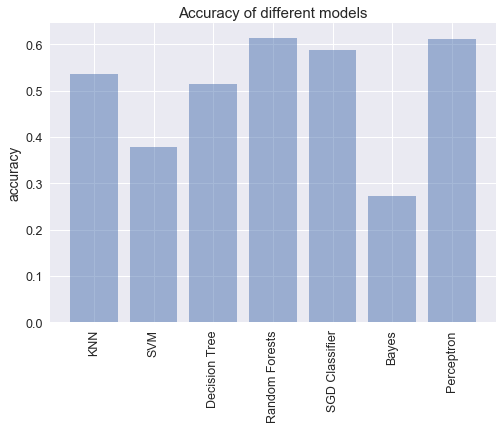

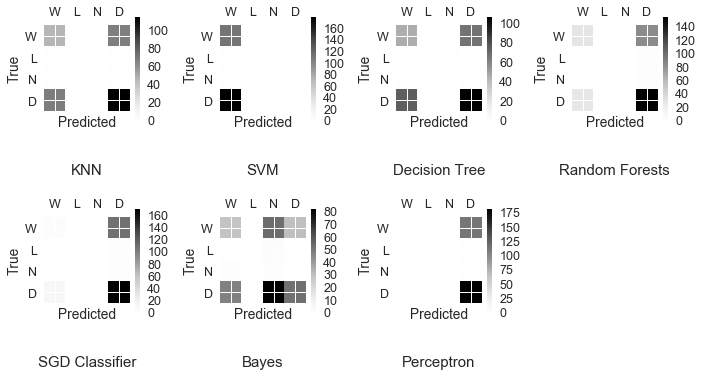

In [30]:
accuracies = run_all_and_Plot(newDF)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['SumRounds'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)

### Reducing Features

This block drops features that are seemingly arbitrary and may have little effect on the data. It drops weight, hometown, event location, event id, fight id, max round and last round. Interestingly, the accuracy scores dip slightly after this is done. I'm not sure I agree with the decisions made here. For instance, I still want to take a look at splitting the columns by city and country. I'm not sure about the others. I'll have to combe back to this later down the road.

KNN 0.520689655172
SVM 0.527586206897
Decision Tree 0.510344827586
Random Forests 0.531034482759
SGD Classifier 0.41724137931
Bayes 0.565517241379
Perceptron 0.465517241379


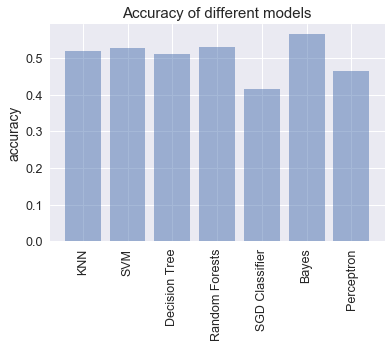

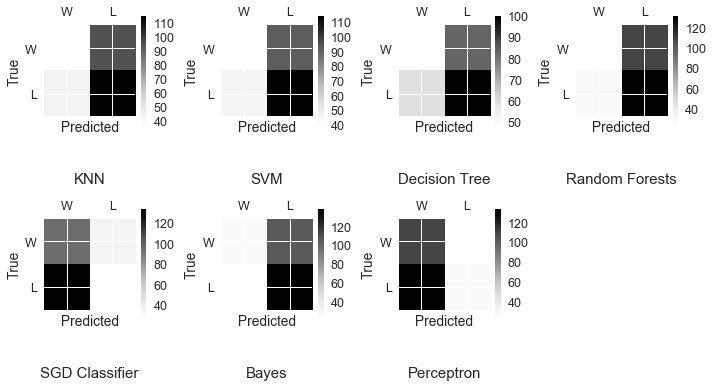

In [187]:
reduced_features = newDF.drop(["Weight","B_HomeTown","B_Location", "Event_ID", "Fight_ID", "Max_round", "Last_round", "R_HomeTown", "R_Location"],axis = 1)
accuracies = run_all_and_Plot(reduced_features)
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
CompareAll['Reduced Features'] = accuracies
plot_bar(accuracies)
plot_cm(accuracies)


In [31]:
reduced_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 93 columns):
winby                                          1477 non-null int8
winner                                         1477 non-null int8
Strikes_Distance Head Kicks_Attempts           1477 non-null float64
Strikes_Distance Leg Kicks_Landed              1477 non-null float64
Strikes_Distance Head Strikes_Attempts         1477 non-null float64
Strikes_Head Significant Strikes_Landed        1477 non-null float64
Strikes_Distance Body Punches_Landed           1477 non-null float64
Strikes_Legs Significant Strikes_Attempts      1477 non-null float64
Strikes_Ground Head Strikes_Landed             1477 non-null float64
Strikes_Clinch Body Strikes_Landed             1477 non-null float64
TIP_Clinch Time                                1477 non-null float64
Strikes_Legs Total Strikes_Landed              1477 non-null float64
Strikes_Clinch Total Strikes_Landed            1477 non-null float64
St

In [36]:
sorted(reduced_features.columns.values.tolist())

['Age',
 'Grappling_Reversals_Landed',
 'Grappling_Standups_Landed',
 'Grappling_Submissions_Attempts',
 'Grappling_Takedowns_Attempts',
 'Grappling_Takedowns_Landed',
 'Height',
 'Prev',
 'Streak',
 'Strikes_Body Significant Strikes_Attempts',
 'Strikes_Body Significant Strikes_Landed',
 'Strikes_Body Total Strikes_Attempts',
 'Strikes_Body Total Strikes_Landed',
 'Strikes_Clinch Body Strikes_Attempts',
 'Strikes_Clinch Body Strikes_Landed',
 'Strikes_Clinch Head Strikes_Attempts',
 'Strikes_Clinch Head Strikes_Landed',
 'Strikes_Clinch Leg Strikes_Attempts',
 'Strikes_Clinch Leg Strikes_Landed',
 'Strikes_Clinch Significant Kicks_Attempts',
 'Strikes_Clinch Significant Kicks_Landed',
 'Strikes_Clinch Significant Punches_Attempts',
 'Strikes_Clinch Significant Punches_Landed',
 'Strikes_Clinch Significant Strikes_Attempts',
 'Strikes_Clinch Significant Strikes_Landed',
 'Strikes_Clinch Total Strikes_Attempts',
 'Strikes_Clinch Total Strikes_Landed',
 'Strikes_Distance Body Kicks_Attem

## Conclusion
Our model has a best predictive value that lies between 58-63% on average between runs. Despite a very low accuracy model, we believe this is the best possible given the amount of available data and its inherent noise. 

## Stretch Goals

### Rewrite and re-run scraper to pull data from earlier years

It won't be as granular, but it may strengthen the analysis. There might not be enough records from 2014 onwards to model the data accurately. On the other hand, I'm not even sure the previous analyst modeled the data accurately. He took fight data from each fight and used that to predict the winner. That's not realistic. You don't have a round-by-round analysis before the fight happens! It would be much better to use the running totals to predict a fight's outcome. Looks like we're learning Beautiful Soup! At least you have a starting point.
